# Supervised

In this notebook I run 3 different models: Neural Network, KNN, and Random Forest. For every model, I first run the inital model, then conduct hyperparameter tuning, and then evalueate the final model. In the end, I will select the best performing model and use the SHAP method for explainability.

In [30]:
#Basic packages
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Neural network packages
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense

#Random Forest packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#KNN packages
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

#For Explainability
import shap

In [31]:
#Importing data after eda
eda_df = pd.read_csv(r"C:\Users\ottok\OneDrive\Documents\AI_resit_EDA.xlsx")
eda_df.head()

,runtime,genre,worldwide_box_office,theatre_count,avg_run_per_theatre,creative_type,seasons
0,104.0,1,108286422.0,3391.0,4.9,1,2
1,100.0,2,987640.0,3.0,2.1,1,4
2,93.0,2,307.0,819.5,4.2,1,1
3,93.0,2,47019.0,819.5,4.2,1,2
4,107.0,2,143782.0,6.0,3.8,2,3


## Neural Network

Defining input and output features

In [32]:
# Defining X and y
X = eda_df[['runtime', 'genre', 'theatre_count', 'seasons','avg_run_per_theatre', 'creative_type']]
Y = eda_df[['worldwide_box_office']]

# Printing the shapes
print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (5406, 6)
Y shape: (5406, 1)


Splitting the data into test, train and validation

In [33]:
# Splitting the data into training (main), test
X_main, X_test, Y_main, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Splitting training (main) into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_main, Y_main, test_size=0.2, random_state=42)

Scaling the input features. We don't scale output feature because of easier interpretability and the fact that it usually doesn't improve the model's ability to learn from the features.

In [34]:
#Loading the scaler
scaler = StandardScaler()

#Fitting the scaler on training, and transform train
X_train = scaler.fit_transform(X_train)

#Transforming Test and Validation based on same scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#Saving for explainability in the end
X_test_NN = X_test

Initial model

In [35]:
#NN model
NN_model = Sequential()

#First hidden Layer
NN_model.add(Dense(4, input_dim=X_train.shape[1], activation='relu'))

#Second hidden layer
NN_model.add(Dense(2, activation='relu'))

#Output layer
NN_model.add(Dense(Y_train.shape[1], activation='linear'))

#Compiling the model with mean squared error loss and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.75)
NN_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

#Training the model and saving history
history = NN_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=1000)

Epoch 1/50
4/4 [==============================] - 3s 115ms/step - loss: 4723941113331712.0000 - accuracy: 0.0000e+00 - val_loss: 3927469761495040.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 4723908364206080.0000 - accuracy: 0.0000e+00 - val_loss: 3927384130584576.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 4723757503479808.0000 - accuracy: 0.0000e+00 - val_loss: 3927113279209472.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 4723338744168448.0000 - accuracy: 0.0000e+00 - val_loss: 3926491314257920.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 4722457202130944.0000 - accuracy: 0.0000e+00 - val_loss: 3925280938786816.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 4720791828561920.0000 - accuracy: 0.0000e+0

Visualizing the loss

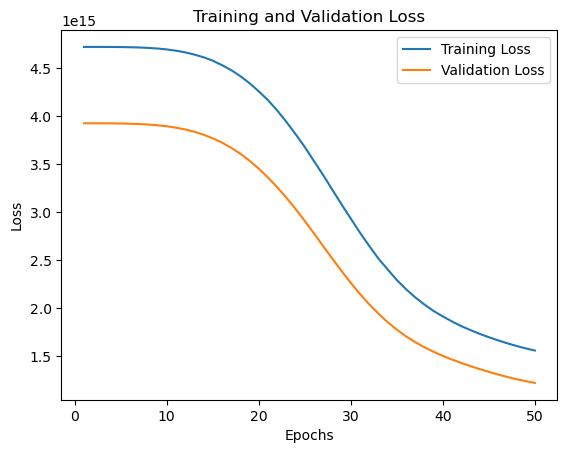

In [36]:
#Accessing the training loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Plotting the training loss and validation loss over epochs
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Regression metrics for the intial model

In [37]:
#Taking input data X_val and predicting the output
y_pred = NN_model.predict(X_val) 

#Evaluating the performance of the NN model using regression metrics
initial_mse_NN = mean_squared_error(Y_val, y_pred)
initial_r2_NN = r2_score(Y_val, y_pred)

#Printing the regression metrics of the NN model
print("Mean Squared Error (MSE) of the neural network model is {}".format(initial_mse_NN))
print("R-squared score of the neural network model is {}".format(initial_r2_NN))


28/28 [==============================] - 0s 1ms/step
Mean Squared Error (MSE) of the neural network model is 1219937407718034.8
R-squared score of the neural network model is 0.5642196997192181


The initial model describes 56% of the variance in target variable worldwide box office.

Hyperparameter tuning

In [38]:
#Hyperparameters I want to test
hyperparam_grid = {
    'epochs': [20, 100, 150], 
    'first_layer_units': [2, 4, 8],
    'second_layer_units': [2, 4, 8],
    'batch_size': [1000, 2000, 3000],
}

#Variables for mse and r-squared
best_mse_score = float('inf')
best_r2_score = float('-inf')
best_params = None

#Looping through my hyperparameter combinations
for epoch in hyperparam_grid['epochs']:
    for first_units in hyperparam_grid['first_layer_units']:
        for units in hyperparam_grid['second_layer_units']:    
            for batch_size in hyperparam_grid['batch_size']:
                #Create and compile the model
                NN_model = Sequential()
                NN_model.add(Dense(first_units, input_dim=X_train.shape[1], activation='relu'))
                #Second hidden layer
                NN_model.add(Dense(units, activation='relu'))
                #output layer
                NN_model.add(Dense(Y_train.shape[1], activation='linear'))
                NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

                #Train the model
                NN_model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=0)

                #Make predictions on the validation set
                y_pred = NN_model.predict(X_val)

                #Calculate MSE
                mse = mean_squared_error(Y_val, y_pred)

                #Calculate R-squared score
                r2 = r2_score(Y_val, y_pred)

                #Check if the current combination is the best
                if mse < best_mse_score:
                    best_mse_score = mse
                    best_r2_score = r2
                    best_params = {'epochs': epoch, 'first_layer_units': first_units, 'units_second_layer': units, 'batch_size': batch_size}


# Calculate improvement percentages
mse_improvement = ((initial_mse_NN - best_mse_score) / initial_mse_NN) * 100
r2_improvement = ((best_r2_score - initial_r2_NN) / (1- initial_r2_NN)) * 100

#Print the best parameters and corresponding scores
print("Best Hyper parameters: ", best_params)
print("Best MSE Score: ", best_mse_score)
print("Best R-squared Score: ", best_r2_score)
print("Improvement over initial NN model (MSE): ", mse_improvement, "%")
print("Improvement over initial NN model (R-squared): ", r2_improvement, "%")


28/28 [==============================] - 0s 2ms/step
Best Hyper parameters:  {'epochs': 150, 'first_layer_units': 8, 'units_second_layer': 8, 'batch_size': 1000}
Best MSE Score:  3927471897967256.0
Best R-squared Score:  -0.4029530303870208
Improvement over initial NN model (MSE):  -221.94044326534956 %
Improvement over initial NN model (R-squared):  -221.94044326534964 %


With hyperparameter tuning we found that r-square actually worsened considerably and was negative.  R-squared can be negative if the model is a poor fit and performs worse than a horizontal line (mean model) fitted to the data.

In the context of a neural network model, a negative R-squared can occur if the model is not trained well, if it's too complex (overfitting) or too simple (underfitting), or if it's not suitable for the specific structure of the data. It indicates that the neural network model is making predictions that are further from the actual values than if you had simply predicted the mean of the target variable.

Final model

In [39]:
# Final model

#Create Model with Tuned Hyperparameters
NN_model = Sequential()

#Layers and Output
NN_model.add(Dense(4, input_dim=X_train.shape[1], activation='relu'))
NN_model.add(Dense(best_params['units_second_layer'], activation='relu'))
NN_model.add(Dense(Y_train.shape[1], activation='linear'))

#Compiling the NN model
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#Training the model
NN_model.fit(X_train, Y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

#Making predictions on the validation set
y_pred = NN_model.predict(X_val)

#Evaluating the performance of the NN model using regression metrics
mse_nn_regression = mean_squared_error(Y_val, y_pred)
r2_nn_regression = r2_score(Y_val, y_pred)

#Printing the regression metrics of the NN model
print("Mean Squared Error (MSE) of the neural network model is {}".format(mse_nn_regression))
print("R-squared score of the neural network model is {}".format(r2_nn_regression))


28/28 [==============================] - 0s 1ms/step
Mean Squared Error (MSE) of the neural network model is 3927475238801679.0
R-squared score of the neural network model is -0.4029542237841728


We conclude that the initial model performs better than the model with hyperparameter tuning.

## KNN

Defining input and output features

In [40]:
# Defining X and y
X = eda_df[['runtime', 'genre', 'theatre_count', 'seasons','avg_run_per_theatre', 'creative_type']]
Y = eda_df[['worldwide_box_office']]

# Printing the shapes
print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (5406, 6)
Y shape: (5406, 1)


Splitting data into test, train and valuation

In [41]:
# Splitting the data into training and test
X_main, X_test, Y_main, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Splitting training (main) into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_main, Y_main, test_size=0.2, random_state=42)

Scaling the input features. We don't scale output feature because of easier interpretability and the fact that it usually doesn't improve the model's ability to learn from the features.

In [42]:
#Loading the scaler
scaler = StandardScaler()

#Fitting the scaler on training, and transforming train
X_train = scaler.fit_transform(X_train)

#Transforming Test and Validation based on same scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#Saving for explainability in the end
X_test_KNN = X_test

Inital KNN model

In [43]:
#Assigning  the KNNmodel
KNN_model = KNeighborsClassifier(n_neighbors=3)

#Fitting the KNN model
KNN_model.fit(X_train, Y_train.values.ravel())

#Making predictions based on validation
y_pred = KNN_model.predict(X_val)

Seeing initial regression metrics

In [44]:
# Making predictions on the validation data using the trained KNN model
y_pred = KNN_model.predict(X_val) 

# Calculating MSE
initial_mse_KNN = mean_squared_error(Y_val, y_pred)

# Calculating R-squared score
initial_r2_KNN = r2_score(Y_val, y_pred)

# Printing the MSE and R-squared score
print("Mean Squared Error (MSE) of the model is {}".format(initial_mse_KNN))
print("R-squared score of the model is {}".format(initial_r2_KNN))


Mean Squared Error (MSE) of the model is 1507232821815798.8
R-squared score of the model is 0.46159338378469417


The initial KNN model describes 46% of the variance in target variable worldwide box office.

Hyperparameter tuning

In [45]:
# K nearest neighbours from 1 to 11 with uneven numbers only
hyperparam_grid = {'n_neighbors': range(1, 13, 2)}

# Score variables
best_mse = float('inf')
best_r2 = float('-inf')
best_K = 0
iteration = 0

# Hyperparameter tuning
for K in hyperparam_grid['n_neighbors']:
    KNN_model = KNeighborsRegressor(n_neighbors=K)
    
    # Fit the model
    KNN_model.fit(X_train, Y_train)
    
    # Make predictions based on validation
    y_pred = KNN_model.predict(X_val)
    
    # Calculate MSE
    mse = mean_squared_error(Y_val, y_pred)
    
    # Calculate R-squared
    r2 = r2_score(Y_val, y_pred)

    # Show MSE and R-squared scores and progress
    iteration += 1
    print("MSE of iteration", iteration, "with K as", K, "=", mse)
    print("R-squared of iteration", iteration, "with K as", K, "=", r2)

    # Check if better and store hyperparameters
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_K = K

# Measure improvement
mse_improvement = ((initial_mse_KNN - best_mse) / initial_mse_KNN) * 100
r2_improvement = ((best_r2 - initial_r2_KNN) / (1 - initial_r2_KNN)) * 100

# Print best hyperparameters and scores
print("\nBest K hyperparameter:", best_K)
print("MSE for best K hyperparameter:", best_mse)
print("R-squared for best K hyperparameter:", best_r2)
print("Improvement over initial KNN (MSE):", mse_improvement, "%")
print("Improvement over initial KNN (R-squared):", r2_improvement, "%")


MSE of iteration 1 with K as 1 = 1914011008190897.8
R-squared of iteration 1 with K as 1 = 0.316285994172141
MSE of iteration 2 with K as 3 = 1116022898766289.1
R-squared of iteration 2 with K as 3 = 0.6013395516296762
MSE of iteration 3 with K as 5 = 963044914722469.5
R-squared of iteration 3 with K as 5 = 0.6559856272407725
MSE of iteration 4 with K as 7 = 963974829616240.6
R-squared of iteration 4 with K as 7 = 0.6556534474182018
MSE of iteration 5 with K as 9 = 956030208690659.6
R-squared of iteration 5 with K as 9 = 0.6584913875212459
MSE of iteration 6 with K as 11 = 961889978522642.6
R-squared of iteration 6 with K as 11 = 0.6563981881154383

Best K hyperparameter: 9
MSE for best K hyperparameter: 956030208690659.6
R-squared for best K hyperparameter: 0.6584913875212459
Improvement over initial KNN (MSE): 36.57050225731499 %
Improvement over initial KNN (R-squared): 36.570502257315 %


The hyperparameter tuning shows us that the best k to us is k=9, which yields a 37% improvement compared to the initial KNN model. Now the model describes 66% of the variance.

Final KNN model

In [46]:
# Assigning the final KNN model with the best K
final_KNN_model = KNeighborsRegressor(n_neighbors=best_K)

# Fitting the model
final_KNN_model.fit(X_train, Y_train)

# Making predictions on the validation data
y_pred = final_KNN_model.predict(X_val)

# Calculating MSE
mse = mean_squared_error(Y_val, y_pred)

# Calculating R-squared
r2 = r2_score(Y_val, y_pred)

# Print the MSE and R-squared
print("Mean Squared Error (MSE) of the final KNN model is {}".format(mse))
print("R-squared score of the final KNN model is {}".format(r2))


Mean Squared Error (MSE) of the final KNN model is 956030208690659.6
R-squared score of the final KNN model is 0.6584913875212459


Actual vs predicted values for the KNN model

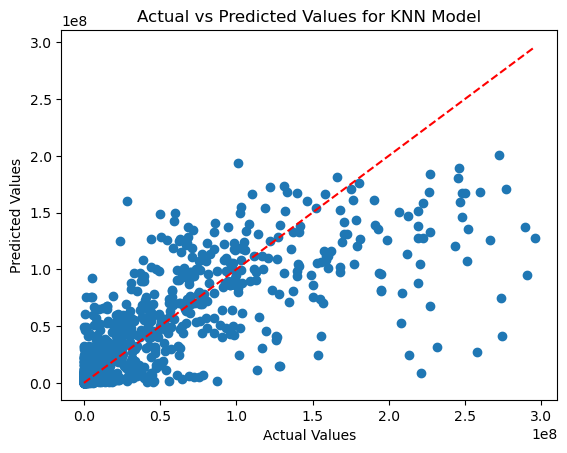

In [47]:
# Making predictions on the test data using the trained KNN model
y_pred = final_KNN_model.predict(X_test)

# Plotting the actual vs predicted values
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # Add diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for KNN Model')
plt.show()

By examining the scatter plot, I can conclude that the model is somewhat able to predict the target variable, because the points on the plot are mostly aligned along the diagonal line (the red dashed line in this case), which indicates that the model's predictions are close to the actual values. This alignment suggests that the model is performing quite well and accurately predicting the target variable.

## Random Forest

Defining input and output features

In [48]:
#Defining X and y
X = eda_df[['runtime', 'genre', 'theatre_count', 'seasons','avg_run_per_theatre', 'creative_type']]
Y = eda_df[['worldwide_box_office']]

#Printing the shapes
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (5406, 6)
Y shape: (5406, 1)


Splitting into test, train and validation

In [49]:
#Splitting the data into training and test
X_main, X_test, Y_main, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Splitting training (main) into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_main, Y_main, test_size=0.2, random_state=42)

Scaling the input features. We don't scale output feature because of easier interpretability and the fact that it usually doesn't improve the model's ability to learn from the features.

In [50]:
#Loading the scaler
scaler = StandardScaler()

#Fitting the scaler on training, and transforming train
X_train = scaler.fit_transform(X_train)

#Transforming Test and Validation based on same scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#Saving for later explainability
X_test_RF = X_test

Initial RF model and regression metrics

In [51]:
#Creating the Random Forest model
rf_model = RandomForestRegressor()

#Fitting the model on the training data
rf_model.fit(X_train, Y_train.values.ravel())

#Making predictions on the validation data
y_pred = rf_model.predict(X_val)

#Calculating the mean squared error
initial_mse_RF = mean_squared_error(Y_val, y_pred)

#Calculating the R-squared score
initial_r2_RF = r2_score(Y_val, y_pred)

#Printing the mean squared error and R-squared score
print("Mean Squared Error (MSE) of the Random Forest model is {}".format(initial_mse_RF))
print("R-squared score of the Random Forest model is {}".format(initial_r2_RF))


Mean Squared Error (MSE) of the Random Forest model is 842617324198144.9
R-squared score of the Random Forest model is 0.6990042044470802


The inital model desribes 70% of the variance in target variable worldwide box office.

Hyperparameter tuning

In [52]:
 #Defining my hyperparameter grid
hyperparam_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Create the Random Forest model
rf_model = RandomForestRegressor()

#Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparam_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train.values.ravel())

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

#Train the model with the best hyperparameters
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, Y_train.values.ravel())

#Make predictions on the validation data
y_pred = rf_model.predict(X_val)

#Calculate the mean squared error
best_mse = mean_squared_error(Y_val, y_pred)

#Calculate the R-squared score
best_r2 = r2_score(Y_val, y_pred)

#Calculate the improvement over the initial model for MSE and R-squared
mse_improvement = ((initial_mse_RF - best_mse) / initial_mse_RF) * 100
r2_improvement = ((best_r2 - initial_r2_RF) / (1 - initial_r2_RF)) * 100


print("Best Hyperparameters:", best_params)
print("Mean Squared Error (MSE) of the Random Forest model is {}".format(best_mse))
print("R-squared score of the Random Forest model is {}".format(best_r2))
print("Improvement over initial MSE: {}%".format(mse_improvement))
print("Improvement over initial R-squared: {}%".format(r2_improvement))


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error (MSE) of the Random Forest model is 822440267362093.1
R-squared score of the Random Forest model is 0.7062117577454452
Improvement over initial MSE: 2.3945694274981504%
Improvement over initial R-squared: 2.3945694274981246%


From hyperparameter tuning, we found out the best hyperparameters for the Random Forest model: 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100. We also see that by using these hyperparameters, we see an increase of 2.4% in the regression metrics compared to the initial model.

Final RF model

In [53]:
#Assigning the final Random Forest model with the best hyperparameters
final_rf_model = RandomForestRegressor(**best_params)

#Fitting the model on the training data
final_rf_model.fit(X_train, Y_train.values.ravel())

#Making predictions on the validation data
y_pred = final_rf_model.predict(X_val)

#Calculating the mean squared error
mse = mean_squared_error(Y_val, y_pred)

#Calculating the R-squared score
r2 = r2_score(Y_val, y_pred)

#Printing the mean squared error and R-squared score
print("Mean Squared Error (MSE) of the final Random Forest model is {}".format(mse))
print("R-squared score of the final Random Forest model is {}".format(r2))


Mean Squared Error (MSE) of the final Random Forest model is 820186371983490.6
R-squared score of the final Random Forest model is 0.7070168836467209


The final model describes 71% of the variance in the target variable worldwide box office.

Actual vs predicted values for the RF model

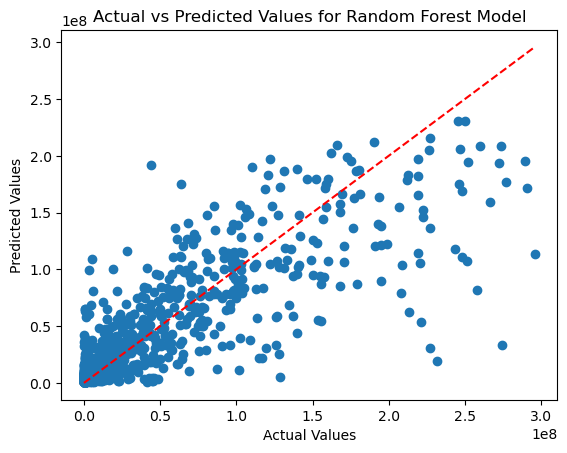

In [54]:
#Making predictions on the test data using the trained Random Forest model
y_pred = final_rf_model.predict(X_test)

#Plotting the actual vs predicted values
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # Add diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Random Forest Model')
plt.show()


By examining the scatter plot, I can conclude that the model is able to predict the target variable, because the points on the plot are mostly aligned along the diagonal line, indicating that the model's predictions are close to the actual values. This alignment suggests that the model is performing quite well and accurately predicting the target variable.

## Conclusion

By examining the regression metrics and the actual vs predicted values for the 3 models, we can conclude that the Random Forest model performs the best out of all with an MSE score of 820186371983490.6, and the R_square score of 0.7070168836467209. Based on the these values, we can draw the following conclusions for the RF model:

MSE: The MSE is quite large, which indicates that the model's predictions often deviate from the actual values by a large amount. This suggests that the model's performance is not optimal and there might be room for improvement.

R-squared: The R-squared value is approximately 0.707, which means that about 71% of the variance in the target variable can be explained by the independent variables in the model. This is a relatively high value and generally indicates a good fit of the model.

In conclusion, while the model is able to explain a significant portion of the variance in the target variable (as indicated by the R-squared value), the large MSE suggests that the model's predictions are not very accurate. This could be due to various reasons such as overfitting, underfitting, or the model not being complex enough to capture the underlying patterns in the data.


## Explainability

In this section we investigate the Random Forest model to see which features contribute the most to predictions made by this model. We do that by using a sample of the test data from the RF model.

In [55]:
#Take test data and take sample
X_test_RF = pd.DataFrame(X_test_RF)
sample = X_test_RF.sample(1000)
#Back to array
sample = sample.to_numpy()

We use the Shap package for explainability. For shap to work an explainer and shap values variable needs to be assigned. The reason we need both an explainer and SHAP values is that the process of computing Shapley values is complex and depends on both the model and the data. The explainer abstracts away this complexity and provides a simple interface to compute the SHAP values. The SHAP values themselves are what we use to understand the model's predictions.

In [56]:
#Shap explainer for RF model with sample data
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(sample)

Global explanation

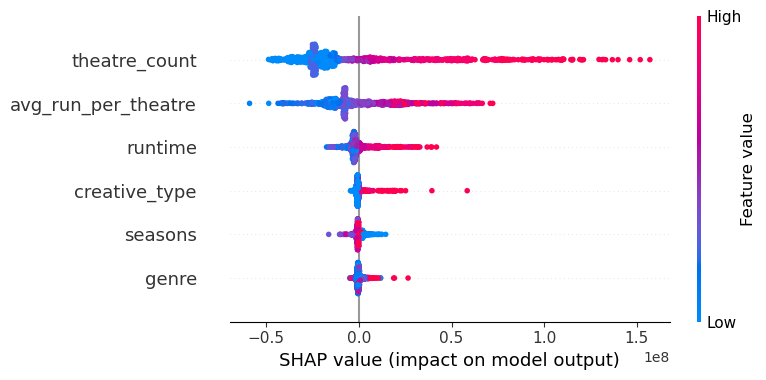

In [57]:
# Create a SHAP summary plot
shap.summary_plot(shap_values, sample, feature_names=X.columns)


From this graph we can see that theatre count and avg run per theatre have the biggest impact on worldwide box office of movies, whereas seasons and genre have the least impact

### Answering the research questions

As a reminder these were my  established research questions:

**"How can we predict worldwide box office of movies based on their various attributes?“**

•	Which model (NN, KNN, RF) works best for predicting worldwide box office?

•	How does genre predict worldwide box office performance of movies?

•	How does runtime predict worldwide box office performance of movies?

•	How does theatre count predict worldwide box office of movies?

•	How does avg run per theatre predict worldwide box office of movies?

•	How does creative type predict worldwide box office of movies?

•	How does a season of release predict worldwide box office of movies?

After conducting the supervised learning, we can see that the Random Forest model works the best. As for the predictors, we find that theatre count and avg run per theatre have the biggest impact in predicting worldwide box office of movies, followed by runtime and creative type (in that order) whereas seasons and genre have the least impact.

Threfore, if studios want to predict worldwide box office of their movies, the best predictors to use are the theater count and the avg run per theater. 